# Analysing billion-objects catalogue interactively: Spark for physicists
<br> Authors: **S. Plaszczynski, J. Peloton, C. Arnault and J.E. Campagne **
<br> ***LAL, Univ. Paris-Sud, CNRS/IN2P3, Universite Paris-Saclay, Orsay, France***
<br> Last Verified to Run: **2019-02-07**



This jupyter notebook describes the analysis presented in  https://arxiv.org/abs/1807.03078
The results presented here were run on the Universite Paris-Sud Spark cluster: https://www.informatique-scientifique.u-psud.fr/services/spark.html

In order to run this notebook you need:
- a cluster running `pypark` (spark version >=2.2) on which the following python libraries have been installed (on each executor):
`matplotlib`,`numpy`,`pandas`,`pyarrow`,`healpy`
- a spark jupyter kernel (NERSC users: https://github.com/astrolabsoftware/spark-kernel-nersc)
- the `SparkFITS` library : https://astrolabsoftware.github.io/spark-fits/
- a set of FITS files, as produced for instance by the `CoLoRe` simulation : https://github.com/damonge/CoLoRe
The directory that points to these files should be put in the FITSDIR environment variable. Any file(s) with (RA,DEC,redshift) coordinates may also be used with little adaptation to match the exact key names.

For testing, Spark (and these dependencies) can also be installed on a personal computer https://spark.apache.org/docs/latest/.

For LSST/DESC collaborators with a NERSC account see https://github.com/LSSTDESC/desc-spark (FITSDIR=/global/cscratch1/sd/plaszczy/LSST10Y)




## Initialisation

In [2]:
from pyspark.sql import SparkSession
from pyspark import StorageLevel
from pyspark.sql import functions as F
from pyspark.sql.functions import randn
from pyspark.sql.types import IntegerType,FloatType
from pyspark.sql.functions import pandas_udf, PandasUDFType

spark = SparkSession.builder.getOrCreate()
sc=spark.sparkContext
print("Spark session started")

#a class for timing
from time import time
class Timer:
    """
    a simple class for printing time (s) since last call
    """
    def __init__(self):
        self.t0=time()
    
    def start(self):
        self.t0=time()
        
    def stop(self):
        t1=time()
        print("{:2.1f}s".format(t1-self.t0))

timer=Timer()

Spark session started


## Reading the data 

all CoLoRe FITS files assumed to be in a directory pointed by the FITSDIR env variable
Le us build the **gal** datafreame selecting only the "RA" and "dec" columns and building a new redshift column called "z" on the flight.

In [2]:
import os
dirfits=os.environ['FITSDIR']
timer.start()
gal=spark.read.format("fits").option("hdu",1)\
         .load(dirfits)\
         .select(F.col("RA"), F.col("Dec"), (F.col("Z_COSMO")+F.col("DZ_RSD")).alias("z"))
timer.stop()

6.1s


Pretty fast isn't it? This is because of lazy evaluation : data have not been actaully loaded (yet). The pipeline (Direct Acyclic Graph, DAG) has been updated but its execution has not been triggered since read/load/slect are not actions but transformations.
At this level the schema of the data is however available so you can looks at it

In [3]:
gal.printSchema()

root
 |-- RA: float (nullable = true)
 |-- Dec: float (nullable = true)
 |-- z: float (nullable = true)



you may want to look at a few values to check eveything is OK. Let's print the first 5

In [4]:
timer.start()
gal.show(5)
timer.stop()

+---------+---------+---------+
|       RA|      Dec|        z|
+---------+---------+---------+
|225.80168|18.519966|2.4199903|
|225.73839|18.588171|2.4056022|
|225.79999|18.635067| 2.396816|
|225.49783|18.570776|2.4139786|
|225.57983|18.638515|2.3995044|
+---------+---------+---------+
only showing top 5 rows

14.1s


Still pretty fast. Here show is an action and has triggered the data access.But not the full data set : since we required only the first 5 rows, the DAG was (automatically) analyzed and only the first block was actually read

Now we add an extra column that performs gaussian smearing on the "z" column. We use the Spark "rand" function that is highly optimized

In [5]:
timer.start()
gal=gal.withColumn("zrec",(gal.z+0.03*(1+gal.z)*randn()).astype('float'))
gal.show(5)
timer.stop()

+---------+---------+---------+---------+
|       RA|      Dec|        z|     zrec|
+---------+---------+---------+---------+
|225.80168|18.519966|2.4199903|2.3029215|
|225.73839|18.588171|2.4056022|2.6602228|
|225.79999|18.635067| 2.396816|2.3686476|
|225.49783|18.570776|2.4139786|2.4345846|
|225.57983|18.638515|2.3995044|2.3599765|
+---------+---------+---------+---------+
only showing top 5 rows

8.3s


Now we have all our columns ready, we put data in cache. Recall that the amount of memory available for the cache is about 60% of your total executors memory. You may simply use the cache() function. Here in case you do not have enough memory we use a slighlty more evolved form that fills the cache and spills the rest over disk if necessary.
Remember to finalize your command with an actiom as count() here.
This is the lenghty part but you need to perform it only once.

In [6]:
timer.start()
print("#galaxies={}".format(gal.persist(StorageLevel.MEMORY_AND_DISK).count()))
timer.stop()

#galaxies=5926764520
97.6s


We put about 6 billions of galaxies in cache, just as if we had a hge RAM. All further computattions will be boosted.

# Basic statistics

Le us first look at some simple statistics on a single column

In [7]:
timer.start()
gal.describe(['z']).show()
timer.stop()

+-------+-------------------+
|summary|                  z|
+-------+-------------------+
|  count|         5926764520|
|   mean|  0.875229446764415|
| stddev|0.47360539212211805|
|    min|        -5.93947E-4|
|    max|          2.4352543|
+-------+-------------------+

5.6s


On all the columns:

In [8]:
timer.start()
gal.describe().show()
timer.stop()

+-------+------------------+--------------------+------------------+-------------------+
|summary|                RA|                 Dec|                 z|               zrec|
+-------+------------------+--------------------+------------------+-------------------+
|  count|        5926764520|          5926764520|        5926764520|         5926764520|
|   mean|179.99419917017775|-0.00314190695924...|0.8752294467644149| 0.8752288274953041|
| stddev|103.92702755739798|   39.17648956108155|0.4736053921221175|0.47714711978268487|
|    min|      4.9597503E-8|          -89.997185|       -5.93947E-4|       -0.124362685|
|    max|             360.0|             89.9986|         2.4352543|            2.95336|
+-------+------------------+--------------------+------------------+-------------------+

9.2s


If you just need some specific values it will be more efficient to call them directly

In [9]:
timer.start()
minmax=gal.select(F.min("z"),F.max("z")).first()
print("min={} max={}".format(minmax[0],minmax[1]))
timer.stop()

min=-0.0005939470138400793 max=2.4352543354034424
4.5s


# Histograms

The distributed way of building histograms is:
- add a column of bin values
- groupBy this column and count the number of elements in each group
- you may then drop the bin and add the center of the bin locations.

## with Spark native functions
Here is how to do it using Spark dataframe functions

In [10]:
#histogram caracteristics
zmin=minmax[0]
zmax=minmax[1]
Nbins=100
dz=(zmax-zmin)/Nbins

#create the bin number column
zbin=gal.select(gal.z,((gal['z']-zmin-dz/2)/dz).cast(IntegerType()).alias('bin'))
# groupBy it + count + sort by bin values
h=zbin.groupBy("bin").count().orderBy(F.asc("bin"))
# add the bin locations (zbin) and drop the bin numer
h=h.select("bin",(zmin+dz/2+h['bin']*dz).alias('loc'),"count").drop("bin")

Now data is reduced to a simple histogram, we go back to the standard python world by converting the dataframe to a pandas object (this is the action so triggers the DAG materialization)

In [11]:
timer.start()
p=h.toPandas()
print(p.columns,"size={}".format(p.index.size))
timer.stop()

Index(['loc', 'count'], dtype='object') size=100
13.0s


Let us plot the result with matplotlib

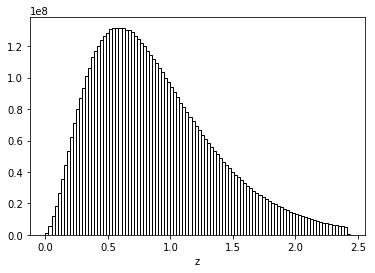

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.bar(p['loc'].values,p['count'].values,dz,color='white',edgecolor='black')
plt.xlabel("z");

## With a User Defined Function (udf)

Although absolutely unnecessary here, we illustrate how one could have plugged an external UDF (to compute the bin number. Performances are extrememly dowgraded so you should NOT do it this way (see next part)

In [14]:
#define your UDF (here just binning)
binNumber_udf=F.udf(lambda z: int((z-zmin)/dz))
timer.start()
#create the bin number column
p_udf=gal.select(gal.z,binNumber_udf(gal.z).alias('bin')).groupBy("bin").count().orderBy(F.asc("bin")).toPandas()
timer.stop()

111.3s


That's not great.Let see how to be more efficient

## With pandas_udf

The recommended way to bind Spark to external python functions is through pandas_udf which achieve some level of vectorization the previous method miss.

In [13]:
import pandas as pd
@pandas_udf("float", PandasUDFType.SCALAR)
def binFloat(z):
    return pd.Series((z-zmin)/dz)
timer.start()
p_udf=gal.select(gal.z,binFloat("z").astype('int').alias('bin')).groupBy("bin").count().orderBy(F.asc("bin")).toPandas()
timer.stop()

46.1s


# Tomography
This is a popular method in cosmology when one builds "shells" in some redshift range of over-densities and compute their 2D power-spectrum (using some spherical pixelization as HealPix). As the redshift decreases, matter clusters more and more and it is expected that these spectra increase in amplitude. Some cross-correlations between nearby bins also appear because of the smearing between the true redhifts ("z") and the observed ones ("zrec").

In [15]:
# define a function that filters galaxies within a redshift range and prject them onto a healpix map
# that is returned

import numpy as np
import healpy as hp

nside=512

def redshift_bin(gal,z1,z2):  
    timer.start()
    #filtering
    shell=gal.filter(gal['zrec'].between(z1,z2))
    print("shell=[{},{}] N={}M".format(z1,z2,shell.count()/1e6))
    
    #projection into healpixels: build a pandas_udf that transforms (ra,dec) into (theta,phi) 
    # and calls healpy ang2pix function          
    @pandas_udf('int', PandasUDFType.SCALAR)
    def Ang2Pix(ra,dec):
        return pd.Series(hp.ang2pix(nside,np.radians(90-dec),np.radians(ra)))
    map=shell.select(Ang2Pix("RA","Dec").alias("ipix")).groupBy("ipix").count().toPandas()
 
    #back to python world
    myMap = np.zeros(hp.nside2npix(nside))
    myMap[map['ipix'].values]=map['count'].values
    timer.stop()
    return myMap

Do a loop over redshift bins  (choosen here so that there are some overlap between adajacent ones for the true redshift) and store the Healpix maps with the number of galaxies in each pixel in a dictionary for later use.

In [54]:
#redshift bins
zshell=[0.0,0.13,0.27,0.43,0.63,0.82,1.05,1.32,1.61,1.95,2.32]
tmap=dict()

#loop over bins and store healpix maps in a dictionary indexed by z1
plt.figure(figsize=(15,10))
for (z1,z2) in zip(zshell[:-1],np.roll(zshell,-1)): 
    tmap[z1]=redshift_bin(gal,z1,z2)    

shell=[0.0,0.13] N=68.557105M
27.8s
shell=[0.13,0.27] N=322.103946M
24.7s
shell=[0.27,0.43] N=669.646368M
30.3s
shell=[0.43,0.63] N=1049.274954M
35.3s
shell=[0.63,0.82] N=980.216568M
37.5s
shell=[0.82,1.05] N=984.086242M
33.9s
shell=[1.05,1.32] N=812.257315M
30.7s
shell=[1.32,1.61] N=529.298439M
30.5s
shell=[1.61,1.95] N=325.212359M
27.8s
shell=[1.95,2.32] N=156.932408M
26.4s


<Figure size 1080x720 with 0 Axes>

Now do a standard analysis as the density contrast power spectra with (standard) healpix functions

bin=[0.0,0.13] mean #gals=21.7937167485555
bin=[0.13,0.27] mean #gals=102.39408683776855
bin=[0.27,0.43] mean #gals=212.87484741210938
bin=[0.43,0.63] mean #gals=333.5555248260498
bin=[0.63,0.82] mean #gals=311.60245513916016
bin=[0.82,1.05] mean #gals=312.83259137471515
bin=[1.05,1.32] mean #gals=258.209646542867
bin=[1.32,1.61] mean #gals=168.25944232940674
bin=[1.61,1.95] mean #gals=103.38222471872966
bin=[1.95,2.32] mean #gals=49.88746897379557


Text(0,0.5,'power spectrum')

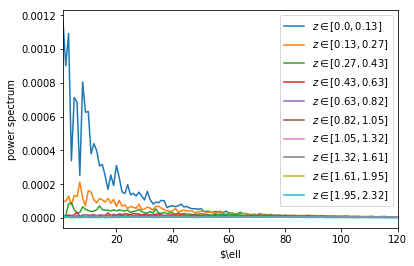

In [59]:
for (z1,z2) in zip(zshell[:-1],np.roll(zshell,-1)): 
    galmap=tmap[z1]
    #compute mean
    Nmean=np.mean(galmap)
    print("bin=[{},{}] mean #gals={}".format(z1,z2,Nmean))
    #and do fractional difference
    dens_map=galmap/Nmean-1
    #compute power-spectrum on the spehere using a standrd healpix function
    cl=hp.anafast(dens_map)
    plt.plot(cl,label=r"$z \in [{},{}]$".format(z1,z2))

plt.xlim(1,120)
plt.legend()
plt.xlabel(r"$\ell$")
plt.ylabel("power spectrum")